# Replication Notebook

This notebook contains the code for computing the consensus labels, the statistics about the labels, as well as the consensus ratios of the participants. 

## Definition of MongoDB Connection

Some parts of the replication kit require a connection to the [SmartSHARK MongoDB Release 1.2](https://smartshark.github.io/dbreleases/). If you do not want to install this database, the following parts of the replication notebook are not supported:
- Extraction of the labels from the MongoDB. This is no problem, because a JSON file with this data is provided.
- Calculation of project statistics
- Analysis of pre-labels for refactorings. 

If you do not run this notebook in a separate container or virtual environment or if you use conda instead of pip, you should consider to do this via the command line.

In [1]:
use_mongodb = True
credentials = {'db_user': '',
               'db_password': '',
               'db_hostname': 'localhost',
               'db_port': 27017,
               'db_authentication_database': '',
               'db_ssl_enabled': False}
database_name = 'smartshark_1_2'

## Installation of Dependencies

If you do not run this notebook in a separate container or virtual environment or if you use conda instead of pip, you should consider to do this via the command line.

In [2]:
import sys
!{sys.executable} -m pip install pycoshark==1.4.2 matplotlib==3.1.3 pandas==0.25.3 seaborn==0.9.0 autorank==1.0.1

## Import dependencies

We first load all modules we need for our analysis. Do not forget to add the imports to cells, if you copy later code to your own environment. 

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from matplotlib.dates import MONTHLY, WEEKLY, DateFormatter, rrulewrapper, RRuleLocator
from pandas.plotting import register_matplotlib_converters

from mongoengine import connect, DoesNotExist
from pycoshark.mongomodels import Commit, FileAction, File, Project, VCSSystem, Hunk, Issue, IssueSystem, Refactoring
from pycoshark.utils import create_mongodb_uri_string, java_filename_filter
from bson import json_util
from scipy import stats
from scipy import optimize
from autorank._util import _confidence_interval
from itertools import chain

register_matplotlib_converters()
plt.rcParams.update({'font.size': 12})

## Definition of the Confidence Levels

Since this impacts multiple parts of the analysis, we configure our very (!) conservative approach for the estimation of confidence intervals here. We correct for all CIs at once, both for 18 confidence intervals for the ratios per commits, and the 27 estimations of the probabilities of mislabels. 

This means we have need to calculate the $1-\frac{0.05}{45} = 0.99\bar{8}$ confidence intervals to have an overall confidence level of 95%.

In [6]:
confidence_level = 1-(0.05/45)

## Load Data from MongoDB (requires use_mongodb==True)

The labelled data was stored in the SmartSHARK MongoDB and the results must be loaded from there first. Please note that this requires that you either have access to our production DB (which you probabaly do not have), our that you must download and install the copy of the database from the replication kit, which is quite large. A description for this is part of the README. 

You can also just skip this part and load the serialized extracted data we also provide as a JSON file. 

In [7]:
if use_mongodb:
    uri = create_mongodb_uri_string(**credentials)
    connect(database_name, host=uri, alias='default')
    
    completed = []
    for h in Hunk.objects(lines_manual__exists=True).only('id', 'lines_manual', 'file_action_id').timeout(False):
        if len(h.lines_manual)>3:
            fa = FileAction.objects(id=h.file_action_id).get()
            file = File.objects(id=fa.file_id).get()
            commit = Commit.objects(id=fa.commit_id).only('revision_hash', 'fixed_issue_ids').get()
            external_id = None
            num_fixed_bugs = 0
            for issue in Issue.objects(id__in=commit.fixed_issue_ids):
                if issue.issue_type_verified is not None and issue.issue_type_verified.lower()=='bug':
                    num_fixed_bugs += 1
                    external_id = issue.external_id
            if num_fixed_bugs==1:
                completed.append({'lines_manual': h.lines_manual,
                                  'file': file.path,
                                  'issue_id': issue.external_id,
                                  'revision_hash':commit.revision_hash,
                                  'hunk_id': h.id})
            else:
                pass # this is just in case we start labeling commits that link to multible bugs

    # store to disk
    with open('data/hunk_labels.json', 'w') as file:
        file.write(json_util.dumps(completed))
else:
    print("skipping (use_mongodb==False)")

## Load Data from JSON

If you skipped the extraction of data from the MongoDB, you can just load the data from the JSON file we provided instead. 

In [8]:
with open('data/hunk_labels.json', 'r') as file:
    completed = json_util.loads(file.read())

## Computation of Consensus Labels

Now that we have all data, we compute the consensus labels. Please note that we reload the data we have just written in the previous cell. This allows you to skip loading the data fresh from the MongoDB and to work with the JSON file we have provided instead. 

In [9]:
for result in completed:
    labels = result['lines_manual']
    first_labels = next(iter(labels.values()))
    lines = []
    for cur_lines in first_labels.values():
        lines.extend(cur_lines)
    
    label_dict = {}
    label_dict_consensus = {}
    for line in lines:
        label_dict[line] = {'bugfix':0, 'whitespace':0, 'documentation':0, 'refactoring':0, 'test':0, 'unrelated':0}
    for user, user_labels in labels.items():
        for label_type, label_lines in user_labels.items():
            if label_type=='bug':
                label_type='bugfix'
                print(result)
            for label_line in label_lines:
                label_dict[label_line][label_type] += 1
    for line, line_labels in label_dict.items():
        has_consensus = False
        for label_type, count in line_labels.items():
            if count>=3:
                # we need this part due to our training issues
                if has_consensus:
                    if count>consensus_count:
                        consensus_count = count
                        label_dict_consensus[line] = label_type                        
                label_dict_consensus[line] = label_type
                has_consensus = True
                consensus_count = count
        if not has_consensus:
            is_java_file = java_filename_filter(result['file'], production_only=False)
            is_prod_file = java_filename_filter(result['file'], production_only=True)
            is_test_file = is_java_file and not is_prod_file
            if is_test_file and line_labels['test']+line_labels['whitespace']+line_labels['documentation']>=4:
                label_dict_consensus[line] = 'test_doc_whitespace'
            elif line_labels['bugfix']==0:
                label_dict_consensus[line] = 'no_bugfix'
            else:
                label_dict_consensus[line] = 'None'
    result['label_dict'] = label_dict
    result['label_dict_consensus'] = label_dict_consensus
    label_dict_by_type = {}
    for line, label in label_dict_consensus.items():
        if label not in label_dict_by_type:
            label_dict_by_type[label] = []
        label_dict_by_type[label].append(line)
    result['label_dict_by_type'] = label_dict_by_type

## Fleiss' kappa

Fleiss' $\kappa$ is a measure for the interrate reliability. The higher the value, the better the quality of our labels, because the individual participants are more reliable. 

In [10]:
n_raters = 4
p_label = {}
p_subject_sum = 0
total_lines = 0
for result in completed:
    for line, label_dict in result['label_dict'].items():
        if sum(label_dict.values())>10:
            continue
        total_lines += 1
        for label, count in label_dict.items():
            if label not in p_label:
                p_label[label] = 0
            p_label[label] += count
            p_subject_sum += count*(count-1)

for label in p_label:
    p_label[label] = p_label[label]/(total_lines*n_raters)
p_subject_sum = p_subject_sum/(n_raters*(n_raters-1))
p_subject_mean = p_subject_sum/total_lines

p_sq_labels = sum([x**2 for x in p_label.values()])
kappa = (p_subject_mean-p_sq_labels)/(1-p_sq_labels)

print('kappa:', kappa)

kappa: 0.6676209461732735


## Compute Statistics for Projects  (requires use_mongodb==True)

We now compute the overview stats on a project level, to give information how many issues/commits were labeled for each project. 

In [11]:
# code adopted from from VisualSHARK leaderboard code
# https://github.com/smartshark/visualSHARK/blob/line_labels/visualSHARK/management/commands/update_leaderboard.py
if use_mongodb:
    uri = create_mongodb_uri_string(**credentials)
    connect(database_name, host=uri, alias='default')
    project_list = ['ant-ivy', 'archiva', 'calcite', 'cayenne', 'commons-bcel', 'commons-beanutils',
                'commons-codec', 'commons-collections', 'commons-compress', 'commons-configuration',
                'commons-dbcp', 'commons-digester', 'commons-io', 'commons-jcs', 'commons-jexl',
                'commons-lang', 'commons-math', 'commons-net', 'commons-scxml',
                'commons-validator', 'commons-vfs', 'deltaspike', 'eagle', 'giraph', 'gora', 'jspwiki',
                'knox', 'kylin', 'lens', 'mahout', 'manifoldcf', 'nutch', 'opennlp', 'parquet-mr',
                'santuario-java', 'systemml', 'tika', 'wss4j']
    #project_list = ['parquet-mr']
    
    projects = {}
    total_bugs = 0
    total_commits = 0
    total_bugs_included = 0
    total_commits_included = 0
    multi_commit_bugs = 0
    multi_commit_commits = 0
    multi_bugfixes = 0
    
    for project_name in project_list:

        if project_name not in projects:
            projects[project_name] = {'need_issues': 0,
                                      'finished_issues': 0,
                                      'need_commits': 0,
                                      'finished_commits': 0,
                                      'partial_commits_1': 0,
                                      'partial_commits_2': 0,
                                      'partial_commits_3': 0}
        project = Project.objects.get(name=project_name)
        its = IssueSystem.objects.get(project_id=project.id)
        vcs = VCSSystem.objects.get(project_id=project.id)
        latest_commit = Commit.objects(vcs_system_id=vcs.id).order_by('committer_date').only('committer_date').first()
        projects[project_name]['start_date'] = latest_commit.committer_date.date().isoformat()                                                              
        projects[project_name]['end_date'] = min(its.last_updated, vcs.last_updated).date().isoformat()
        
        # 1. verified bug issues
        for issue in Issue.objects(issue_system_id=its.id, issue_type_verified='bug'):
            # 2. only issues that are fixed such that not multiple bugs are fixed as part fo the commit
            has_fix = False
            is_multifix = False
            num_commits = Commit.objects(fixed_issue_ids=issue.id).count()
            for commit in Commit.objects(fixed_issue_ids=issue.id).only('id', 'fixed_issue_ids'):
                has_fix = True
                for fix_id in commit.fixed_issue_ids:
                    if fix_id != issue.id:
                        fixed_issue = Issue.objects(id=fix_id).get()
                        if fixed_issue.issue_type_verified is not None and fixed_issue.issue_type_verified=='bug':
                            is_multifix = True
            if has_fix:
                total_bugs += 1
                total_commits += num_commits
                if is_multifix:
                    multi_bugfixes += 1
                elif num_commits>1:
                    multi_commit_bugs += 1
                    multi_commit_commits += num_commits
                if is_multifix:
                    multi_bugfixes += 1
            if not has_fix or is_multifix:
                continue
            total_bugs_included += 1
            total_commits_included += num_commits

            labels = -1
            for commit in Commit.objects(fixed_issue_ids=issue.id).only('id'):
                # the breaks are ugly optimizations
                if labels!=-1:
                    break
                for fa in FileAction.objects(commit_id=commit.id).only('id'):
                    if labels!=-1:
                        break
                    for h in Hunk.objects(file_action_id=fa.id):
                        if labels!=-1:
                            break
                        for username, lines in h.lines_manual.items():
                            if labels!=-1:
                                break
                            labels = len(h.lines_manual)
                            
            projects[project_name]['need_issues'] += 1
            projects[project_name]['need_commits'] += num_commits
            if labels==1:
                projects[project_name]['partial_commits_1'] += num_commits
            if labels==2:
                projects[project_name]['partial_commits_2'] += num_commits
            if labels==3:
                projects[project_name]['partial_commits_3'] += num_commits
            elif labels >= 4:
                projects[project_name]['finished_issues'] += 1
                projects[project_name]['finished_commits'] += num_commits

    print('Total bugs in data:', total_bugs)
    print('Total commits in data :', total_commits)
    print('Bugs fixed in the same commit as other bugs (excluded):', multi_bugfixes)
    print('Total bugs included in study:', total_bugs_included)
    print('Total commits included in study:', total_commits_included)
    print('Number of bugs fixed in multiple commits:', multi_commit_bugs)
    print('Number of commits affected:', multi_commit_commits)
    print()
    print('Partially labeled commits:')
    print('1 Label:', sum([data['partial_commits_1'] for data in projects.values()]))
    print('2 Label:', sum([data['partial_commits_2'] for data in projects.values()]))
    print('3 Label:', sum([data['partial_commits_3'] for data in projects.values()]))
    print()

    total_bugs_needed = 0
    total_bugs_finished = 0
    total_commits_needed = 0
    total_commits_finished = 0
    for project, data in projects.items():
        if data['finished_issues']>0:
            total_bugs_needed += data['need_issues']
            total_bugs_finished += data['finished_issues']
            total_commits_needed += data['need_commits']
            total_commits_finished += data['finished_commits']
            print('%s & %s -- %s & %d / %d & %d / %d \\\\' % (project,
                                                              data['start_date'],
                                                              data['end_date'],
                                                              data['finished_issues'],
                                                              data['need_issues'],
                                                              data['finished_commits'],
                                                              data['need_commits']))
    print('\\hline')
    print('Total && %d / %d & %d / %d \\\\' % (total_bugs_finished, total_bugs_needed, total_commits_finished, total_commits_needed))
else:
    print('skipping (use_mongodb==False)')

Total bugs in data: 6533
Total commits in data : 10878
Bugs fixed in the same commit as other bugs (excluded): 508
Total bugs included in study: 6279
Total commits included in study: 10389
Number of bugs fixed in multiple commits: 2283
Number of commits affected: 6393

Partially labeled commits:
1 Label: 1389
2 Label: 683
3 Label: 303

ant-ivy & 2005-06-16 -- 2018-02-13 & 404 / 404 & 547 / 547 \\
archiva & 2005-11-23 -- 2018-07-25 & 3 / 278 & 4 / 509 \\
commons-bcel & 2001-10-29 -- 2019-03-12 & 33 / 33 & 52 / 52 \\
commons-beanutils & 2001-03-27 -- 2018-11-15 & 47 / 47 & 60 / 60 \\
commons-codec & 2003-04-25 -- 2018-11-15 & 27 / 27 & 58 / 58 \\
commons-collections & 2001-04-14 -- 2018-11-15 & 48 / 48 & 93 / 93 \\
commons-compress & 2003-11-23 -- 2018-11-15 & 119 / 119 & 205 / 205 \\
commons-configuration & 2003-12-23 -- 2018-11-15 & 140 / 140 & 253 / 253 \\
commons-dbcp & 2001-04-14 -- 2019-03-12 & 57 / 57 & 89 / 89 \\
commons-digester & 2001-05-03 -- 2018-11-16 & 17 / 17 & 26 / 26 \\


## Compute Line Label Statistics

We can now start to analyze our data. First, we generate the values for our variables. This means we count how many lines of each label type we have and that we compute the percentages, both with respect to all changes and the production changes. We also report the changes for other Java code, i.e., non-production code like tests or documentation. 

In [12]:
line_counts_all = {}
line_counts_java = {}
line_counts_prod = {}
for result in completed:
    for label, lines in result['label_dict_by_type'].items():
        if label not in line_counts_all:
            line_counts_all[label] = 0
        line_counts_all[label] += len(lines)
        if java_filename_filter(result['file'], production_only=False):
            if label not in line_counts_java:
                line_counts_java[label] = 0
            line_counts_java[label] += len(lines)
        if java_filename_filter(result['file'], production_only=True):
            if label not in line_counts_prod:
                line_counts_prod[label] = 0
            line_counts_prod[label] += len(lines)
for key in line_counts_all.keys():
    if key not in line_counts_java:
        line_counts_java = 0
    if key not in line_counts_prod:
        line_counts_prod[key] = 0
        
line_counts_noprod = {}
for key in line_counts_java:
    line_counts_noprod[key] = line_counts_java[key]-line_counts_prod[key]


print('Bugfix & %d & (%.1f\\%%) & %d & (%.1f\\%%) & %d & (%.1f\\%%) \\\\' % (line_counts_all['bugfix'], 100*line_counts_all['bugfix']/sum(line_counts_all.values()),
                                                                       line_counts_prod['bugfix'], 100*line_counts_prod['bugfix']/sum(line_counts_prod.values()),
                                                                       line_counts_noprod['bugfix'], 100*line_counts_noprod['bugfix']/sum(line_counts_noprod.values())))
print('Test & %d & (%.1f\\%%) & %d & (%.1f\\%%) & %d & (%.1f\\%%) \\\\' % (line_counts_all['test'], 100*line_counts_all['test']/sum(line_counts_all.values()),
                                                                     line_counts_prod['test'], 100*line_counts_prod['test']/sum(line_counts_prod.values()),
                                                                     line_counts_noprod['test'], 100*line_counts_noprod['test']/sum(line_counts_noprod.values())))
print('Documentation & %d & (%.1f\\%%) & %d & (%.1f\\%%) & %d & (%.1f\\%%) \\\\' % (line_counts_all['documentation'], 100*line_counts_all['documentation']/sum(line_counts_all.values()),
                                                                              line_counts_prod['documentation'], 100*line_counts_prod['documentation']/sum(line_counts_prod.values()),
                                                                              line_counts_noprod['documentation'], 100*line_counts_noprod['documentation']/sum(line_counts_noprod.values())))
print('Refactoring & %d & (%.1f\\%%) & %d & (%.1f\\%%) & %d & (%.1f\\%%) \\\\' % (line_counts_all['refactoring'], 100*line_counts_all['refactoring']/sum(line_counts_all.values()),
                                                                                      line_counts_prod['refactoring'], 100*line_counts_prod['refactoring']/sum(line_counts_prod.values()),
                                                                                      line_counts_noprod['refactoring'], 100*line_counts_noprod['refactoring']/sum(line_counts_noprod.values())))
print('Unrelated Improvement & %d & (%.1f\\%%) & %d & (%.1f\\%%) & %d & (%.1f\\%%) \\\\' % (line_counts_all['unrelated'], 100*line_counts_all['unrelated']/sum(line_counts_all.values()),
                                                                                      line_counts_prod['unrelated'], 100*line_counts_prod['unrelated']/sum(line_counts_prod.values()),
                                                                                      line_counts_noprod['unrelated'], 100*line_counts_noprod['unrelated']/sum(line_counts_noprod.values())))
print('Whitespace & %d & (%.1f\\%%) & %d & (%.1f\\%%) & %d & (%.1f\\%%) \\\\' % (line_counts_all['whitespace'], 100*line_counts_all['whitespace']/sum(line_counts_all.values()),
                                                                           line_counts_prod['whitespace'], 100*line_counts_prod['whitespace']/sum(line_counts_prod.values()),
                                                                           line_counts_noprod['whitespace'], 100*line_counts_noprod['whitespace']/sum(line_counts_noprod.values())))
print('\\hline')
print('Test/Doc/Whitespace & %d & (%.1f\\%%) & %d & (%.1f\\%%) & %d & (%.1f\\%%) \\\\' % (line_counts_all['test_doc_whitespace'], 100*line_counts_all['test_doc_whitespace']/sum(line_counts_all.values()),
                                                                                              line_counts_prod['test_doc_whitespace'], 100*line_counts_prod['test_doc_whitespace']/sum(line_counts_prod.values()),
                                                                                              line_counts_noprod['test_doc_whitespace'], 100*line_counts_noprod['test_doc_whitespace']/sum(line_counts_noprod.values())))
print('No Bugfix & %d & (%.1f\\%%) & %d & (%.1f\\%%) & %d & (%.1f\\%%) \\\\' % (line_counts_all['no_bugfix'], 100*line_counts_all['no_bugfix']/sum(line_counts_all.values()),
                                                                          line_counts_prod['no_bugfix'], 100*line_counts_prod['no_bugfix']/sum(line_counts_prod.values()),
                                                                          line_counts_noprod['no_bugfix'], 100*line_counts_noprod['no_bugfix']/sum(line_counts_noprod.values())))
print('No Consensus & %d & (%.1f\\%%) & %d & (%.1f\\%%) & %d & (%.1f\\%%) \\\\' % (line_counts_all['None'], 100*line_counts_all['None']/sum(line_counts_all.values()),
                                                                             line_counts_prod['None'], 100*line_counts_prod['None']/sum(line_counts_prod.values()),
                                                                             line_counts_noprod['None'], 100*line_counts_noprod['None']/sum(line_counts_noprod.values())))
print('\\hline')
print('Total & %d && %d && %d \\\\' % (sum(line_counts_all.values()), sum(line_counts_prod.values()), sum(line_counts_noprod.values())))

Bugfix & 72774 & (25.1\%) & 71343 & (49.2\%) & 361 & (0.3\%) \\
Test & 114765 & (39.6\%) & 8 & (0.0\%) & 102126 & (91.3\%) \\
Documentation & 40456 & (14.0\%) & 31472 & (21.7\%) & 749 & (0.7\%) \\
Refactoring & 5297 & (1.8\%) & 5294 & (3.7\%) & 3 & (0.0\%) \\
Unrelated Improvement & 1361 & (0.5\%) & 824 & (0.6\%) & 11 & (0.0\%) \\
Whitespace & 11909 & (4.1\%) & 10771 & (7.4\%) & 781 & (0.7\%) \\
\hline
Test/Doc/Whitespace & 4454 & (1.5\%) & 0 & (0.0\%) & 4454 & (4.0\%) \\
No Bugfix & 13052 & (4.5\%) & 4429 & (3.1\%) & 1754 & (1.6\%) \\
No Consensus & 25836 & (8.9\%) & 20722 & (14.3\%) & 1587 & (1.4\%) \\
\hline
Total & 289904 && 144863 && 111826 \\


## Commit Level Analysis

After the overall statistics, we now consider our variables on a commit level to understand how the different labels vary in the commits. 

Bugfix & 25.0 & 34.8 & [22.2, 29.2] & 75.0 & 37.1 & [70.6, 79.2] & 95.5 \\
Test & 13.0 & 19.3 & [0.0, 23.4] & 0.0 & 0.0 & [0.0, 0.0] & 0.1 \\
Documentation & 10.2 & 15.1 & [7.8, 12.5] & 0.0 & 0.0 & [0.0, 5.1] & 49.4 \\
Refactoring & 0.0 & 0.0 & [0.0, 0.0] & 0.0 & 0.0 & [0.0, 0.0] & 7.8 \\
Unrelated Improvement & 0.0 & 0.0 & [0.0, 0.0] & 0.0 & 0.0 & [0.0, 0.0] & 2.9 \\
Whitespace & 0.0 & 0.0 & [0.0, 0.0] & 0.0 & 0.0 & [0.0, 1.7] & 46.9 \\
Test/Doc/Whitespace & 0.0 & 0.0 & [0.0, 0.0] & 0.0 & 0.0 & [0.0, 0.0] & 0.0 \\
No Bugfix & 0.0 & 0.0 & [0.0, 0.0] & 0.0 & 0.0 & [0.0, 0.0] & 5.8 \\
No Consensus & 0.0 & 0.0 & [0.0, 0.0] & 0.0 & 0.0 & [0.0, 0.0] & 29.7 \\


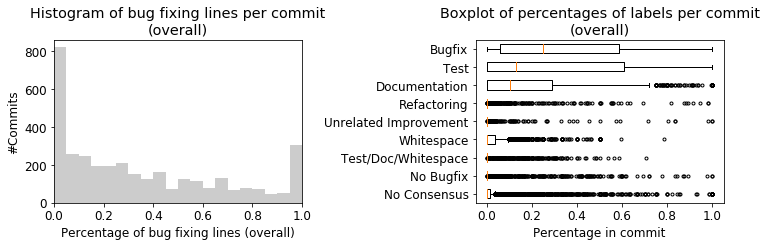

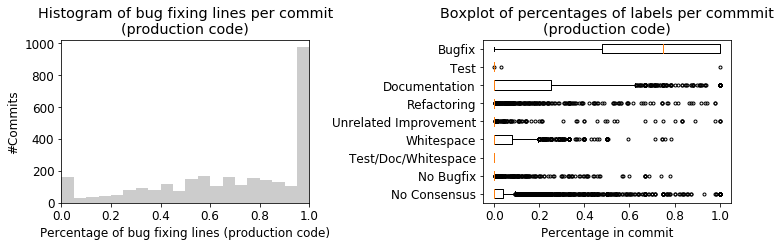

In [13]:
commit_ratios_all = {}
commit_ratios_java = {}
commit_ratios_prod = {}
for result in completed:
    if result['revision_hash'] not in commit_ratios_all:
        commit_ratios_all[result['revision_hash']] = {}
        #commit_ratios_java[result['revision_hash']] = {}
        #commit_ratios_prod[result['revision_hash']] = {}
    for label, lines in result['label_dict_by_type'].items():
        if label not in commit_ratios_all[result['revision_hash']]:
            commit_ratios_all[result['revision_hash']][label] = 0
        commit_ratios_all[result['revision_hash']][label] += len(lines)
        if java_filename_filter(result['file'], production_only=False):
            if result['revision_hash'] not in commit_ratios_java:
                commit_ratios_java[result['revision_hash']] = {}
            if label not in commit_ratios_java[result['revision_hash']]:
                commit_ratios_java[result['revision_hash']][label] = 0
            commit_ratios_java[result['revision_hash']][label] += len(lines)
        if java_filename_filter(result['file'], production_only=True):
            if result['revision_hash'] not in commit_ratios_prod:
                commit_ratios_prod[result['revision_hash']] = {}
            if label not in commit_ratios_prod[result['revision_hash']]:
                commit_ratios_prod[result['revision_hash']][label] = 0
            commit_ratios_prod[result['revision_hash']][label] += len(lines)

        
commit_ratios_all_df = pd.DataFrame(commit_ratios_all).fillna(0).transpose()
commit_ratios_all_df = commit_ratios_all_df.div(commit_ratios_all_df.sum(axis=1), axis=0)

commit_ratios_java_df = pd.DataFrame(commit_ratios_java).fillna(0).transpose()
commit_ratios_java_df = commit_ratios_java_df.div(commit_ratios_java_df.sum(axis=1), axis=0).fillna(0)

commit_ratios_prod_df = pd.DataFrame(commit_ratios_prod).fillna(0).transpose()
commit_ratios_prod_df = commit_ratios_prod_df.div(commit_ratios_prod_df.sum(axis=1), axis=0).fillna(0)
commit_ratios_prod_df['total_lines'] = pd.DataFrame(commit_ratios_prod).fillna(0).transpose().sum(axis=1)


# add empty columns of types not observed - required for plots
for column in commit_ratios_all_df.columns:
    if column not in commit_ratios_java_df.columns:
        commit_ratios_java_df[column] = 0.0
    if column not in commit_ratios_prod_df.columns:
        commit_ratios_prod_df[column] = 0.0

# create stats table
col_order = ['bugfix', 'test', 'documentation', 'refactoring', 'unrelated', 'whitespace', 'test_doc_whitespace', 'no_bugfix', 'None']
box_labels = ['Bugfix', 'Test', 'Documentation', 'Refactoring', 'Unrelated Improvement', 'Whitespace', 'Test/Doc/Whitespace', 'No Bugfix', 'No Consensus']

for col, label in zip(col_order, box_labels):
    lower_all, upper_all = _confidence_interval(commit_ratios_all_df[col], 1-confidence_level, is_normal=False)
    lower_prod, upper_prod = _confidence_interval(commit_ratios_prod_df[col], 1-confidence_level, is_normal=False)
    gt_zero = sum(commit_ratios_prod_df[col]>0)/len(commit_ratios_prod_df)
    print("%s & %.1f & %.1f & [%.1f, %.1f] & %.1f & %.1f & [%.1f, %.1f] & %.1f \\\\" % 
          (label,
           100*commit_ratios_all_df[col].median(),
           100*stats.median_abs_deviation(commit_ratios_all_df[col], scale=1/1.4826),
           100*lower_all, 100*upper_all,
           100*commit_ratios_prod_df[col].median(),
           100*stats.median_abs_deviation(commit_ratios_prod_df[col], scale=1/1.4826),
           100*lower_prod, 100*upper_prod,
           100*gt_zero))
    
# create plots
# we need to reverse this, because matplotlib starts at the bottom
col_order.reverse()
box_labels.reverse()

fig, axes = plt.subplots(1,2, figsize=(12,3))
ax = axes[0]
sns.distplot(commit_ratios_all_df['bugfix'], rug=False, bins=20, kde=False, color='grey', ax=ax)
ax.set_title('Histogram of bug fixing lines per commit\n(overall)')
ax.set_xlabel('Percentage of bug fixing lines (overall)')
ax.set_ylabel('#Commits')
ax.set_xlim(0,1)

ax = axes[1]
ax.boxplot(commit_ratios_all_df[col_order].values, labels=box_labels, vert=False, flierprops={'marker':'.'})
ax.set_title('Boxplot of percentages of labels per commit\n(overall)')
ax.set_xlabel('Percentage in commit')

plt.subplots_adjust(wspace=0.7)
plt.savefig('figures/commits_all.pdf', bbox_inches='tight')

fig, axes = plt.subplots(1,2, figsize=(12,3))
ax = axes[0]
sns.distplot(commit_ratios_prod_df['bugfix'], rug=False, bins=20, kde=False, color='grey', ax=ax)
ax.set_title('Histogram of bug fixing lines per commit\n(production code)')
ax.set_xlabel('Percentage of bug fixing lines (production code)')
ax.set_ylabel('#Commits')
ax.set_xlim(0,1)

ax = axes[1]
ax.boxplot(commit_ratios_prod_df[col_order].values, labels=box_labels, vert=False, flierprops={'marker':'.'})
ax.set_title('Boxplot of percentages of labels per commmit\n(production code)')
ax.set_xlabel('Percentage in commit')

plt.subplots_adjust(wspace=0.7)
plt.savefig('figures/commits_prod.pdf', bbox_inches='tight')

We also visualize the relationship between the size and the mislabels. While this is not part of the actual analysis, we use this to address the potential threat to validity that the mislabels are driven by the size, e.g., larger changes mean that a lower percentage of the change is bugfixing. First, we consider the relationship between the commit sizes and the labels. We already have all relevant data from the prior analysis. 

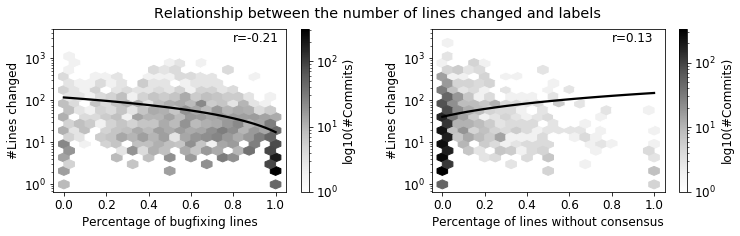

In [14]:
fig, axes = plt.subplots(1,2, figsize=(12,3))
plt.suptitle('Relationship between the number of lines changed and labels')

ax = axes[0]
sns.regplot(x="bugfix", y="total_lines", data=commit_ratios_prod_df, ax=ax, color='black', scatter=False, ci=None)
hb = ax.hexbin(commit_ratios_prod_df['bugfix'], commit_ratios_prod_df['total_lines'], C=None, gridsize=20, mincnt=1, bins='log', xscale='linear', yscale='log', cmap='Greys')
cb = fig.colorbar(hb, ax=ax)
ax.set_xlabel('Percentage of bugfixing lines')
ax.set_ylabel('#Lines changed')
cb.set_label('log10(#Commits)')
ax.text(y=2.5*10**3, x=0.8, s='r=%.2f' % commit_ratios_prod_df.corr(method='pearson').loc['bugfix', 'total_lines'])

ax = axes[1]
sns.regplot(x="None", y="total_lines", data=commit_ratios_prod_df, ax=ax, color='black', scatter=False, ci=None)
hb = ax.hexbin(commit_ratios_prod_df['None'], commit_ratios_prod_df['total_lines'], C=None, gridsize=20, mincnt=1, bins='log', xscale='linear', yscale='log', cmap='Greys')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(#Commits)')
ax.set_xlabel('Percentage of lines without consensus')
ax.set_ylabel('#Lines changed')
ax.text(y=2.5*10**3, x=0.8, s='r=%.2f' % commit_ratios_prod_df.corr(method='pearson').loc['None', 'total_lines'])

plt.subplots_adjust(wspace=0.3)
plt.savefig('figures/size_relationship.pdf', bbox_inches='tight')

Next, we visualize the relationship between the number of commits for fixing a bug and the labels.

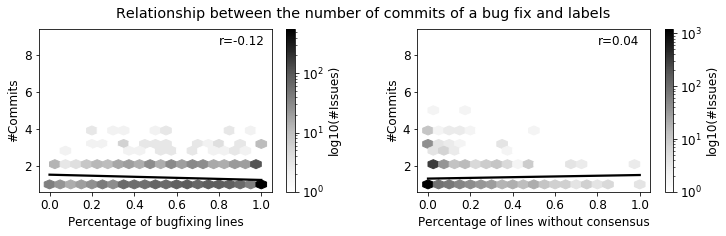

In [15]:
issue_ratios_all = {}
issue_ratios_java = {}
issue_ratios_prod = {}
for result in completed:
    if result['issue_id'] not in issue_ratios_all:
        issue_ratios_all[result['issue_id']] = {}
    for label, lines in result['label_dict_by_type'].items():
        if label not in issue_ratios_all[result['issue_id']]:
            issue_ratios_all[result['issue_id']][label] = 0
        issue_ratios_all[result['issue_id']][label] += len(lines)
        if java_filename_filter(result['file'], production_only=False):
            if result['issue_id'] not in issue_ratios_java:
                issue_ratios_java[result['issue_id']] = {}
            if label not in issue_ratios_java[result['issue_id']]:
                issue_ratios_java[result['issue_id']][label] = 0
            issue_ratios_java[result['issue_id']][label] += len(lines)
        if java_filename_filter(result['file'], production_only=True):
            if result['issue_id'] not in issue_ratios_prod:
                issue_ratios_prod[result['issue_id']] = {}
                issue_ratios_prod[result['issue_id']]['commits'] = set()
            if label not in issue_ratios_prod[result['issue_id']]:
                issue_ratios_prod[result['issue_id']][label] = 0
            issue_ratios_prod[result['issue_id']][label] += len(lines)
            issue_ratios_prod[result['issue_id']]['commits'].add(result['revision_hash'])

num_commits = []
for issue in issue_ratios_prod:
    num_commits.append(len(issue_ratios_prod[issue]['commits']))
    issue_ratios_prod[issue].pop('commits', None)
    
issue_ratios_prod_df = pd.DataFrame(issue_ratios_prod).fillna(0).transpose()
issue_ratios_prod_df = issue_ratios_prod_df.div(issue_ratios_prod_df.sum(axis=1), axis=0).fillna(0)
issue_ratios_prod_df['num_commits'] = num_commits

fig, axes = plt.subplots(1,2, figsize=(12,3))
plt.suptitle('Relationship between the number of commits of a bug fix and labels')
ax = axes[0]
sns.regplot(x="bugfix", y="num_commits", data=issue_ratios_prod_df, ax=ax, color='black', scatter=False, ci=None)
hb = ax.hexbin(issue_ratios_prod_df['bugfix'], issue_ratios_prod_df['num_commits'], C=None, gridsize=20, mincnt=1, bins='log', xscale='linear', yscale='linear', cmap='Greys')
cb = fig.colorbar(hb, ax=ax)
ax.set_xlabel('Percentage of bugfixing lines')
ax.set_ylabel('#Commits')
cb.set_label('log10(#Issues)')
ax.text(y=8.5, x=0.8, s='r=%.2f' % issue_ratios_prod_df.corr(method='pearson').loc['bugfix', 'num_commits'])

ax = axes[1]
sns.regplot(x="None", y="num_commits", data=issue_ratios_prod_df, ax=ax, color='black', scatter=False, ci=None)
hb = ax.hexbin(issue_ratios_prod_df['None'], issue_ratios_prod_df['num_commits'], C=None, gridsize=20, mincnt=1, bins='log', xscale='linear', yscale='linear', cmap='Greys')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(#Issues)')
ax.set_xlabel('Percentage of lines without consensus')
ax.set_ylabel('#Commits')
ax.text(y=8.5, x=0.8, s='r=%.2f' % issue_ratios_prod_df.corr(method='pearson').loc['None', 'num_commits'])

plt.subplots_adjust(wspace=0.3)
plt.savefig('figures/num_commits_relationship.pdf', bbox_inches='tight')

# Analysis of Probabilites of Mislabels on Bugfix lines

We now analyze the probabilities of mislabels. We estimate them using the minority votes in the consensus lines. We use the estimates to estimate how many lines without consensus would be expected, under the assumption that lines without consensus are an artifact of random effects. 

Probability of any mislabel in all lines: 7.5 +- 0.0
Expected count of non consensus labels in all lines: 8449 - 8449
Probability of any mislabel in production code: 9.0 +- 0.0
Expected count of non consensus labels in production code: 5843 - 5843

Bugfix & - & $0.1 \pm 0.0$ & $3.6 \pm 0.0$ & $4.2 \pm 0.0$ & $0.7 \pm 0.0$ & $0.2 \pm 0.0$ \\
Documentation & $3.3 \pm 0.0$ & - & $0.8 \pm 0.0$ & $1.6 \pm 0.0$ & $0.9 \pm 0.0$ & $0.3 \pm 0.0$ \\
Refactoring & $13.7 \pm 0.0$ & $0.7 \pm 0.0$ & - & $3.4 \pm 0.0$ & $0.9 \pm 0.0$ & $0.0 \pm 0.0$ \\
Unrelated & $18.5 \pm 0.0$ & $0.8 \pm 0.0$ & $1.9 \pm 0.0$ & - & $1.2 \pm 0.0$ & $0.0 \pm 0.0$ \\
Whitespace & $4.2 \pm 0.0$ & $0.3 \pm 0.0$ & $2.8 \pm 0.0$ & $2.4 \pm 0.0$ & - & $0.5 \pm 0.0$ \\

Bugfix & - & 1 & 508 & 705 & 23 & 2 \\
Documentation & 189 & - & 11 & 47 & 17 & 2 \\
Refactoring & 446 & 2 & - & 35 & 3 & 0 \\
Unrelated & 110 & 0 & 2 & - & 1 & 0 \\
Whitespace & 103 & 1 & 49 & 34 & - & 1 \\
\hline
Total Expected: & 847 & 3 & 570 & 821 & 42 &

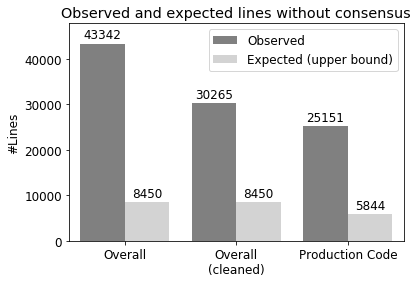

In [16]:
possible_labels = ['bugfix', 'documentation', 'refactoring', 'unrelated', 'whitespace', 'test']
systematic_error_label = ['test_doc_whitespace', 'no_bugfix']

none_combinations = {}
for result in completed:
    if not java_filename_filter(result['file'], production_only=True):
        continue
    for line, label in result['label_dict_consensus'].items():
        if label in possible_labels: #label!='None':
            continue
        user_labels = ', '.join(sorted([str(value)+' '+key for key, value in result['label_dict'][line].items() if value>0]))
        if user_labels not in none_combinations:
            none_combinations[user_labels] = 0
        none_combinations[user_labels] += 1

mislabel_probs = pd.DataFrame(0, index=possible_labels, columns=possible_labels)
mislabel_cis = pd.DataFrame(0, index=possible_labels, columns=possible_labels)
label_counts = {}
for label in possible_labels:
    label_counts[label] = 0
non_prod_lines = 0
non_prod_lines_mislabels = 0
total_lines_prod = 0
total_lines = 0
systematic_errors = 0

for result in completed:
    for line, labels in result['label_dict'].items():
        if sum(labels.values())>10:
            continue # skip tutorial
        total_lines += 1
        consensus_label = result['label_dict_consensus'][line]
        if java_filename_filter(result['file'], production_only=True):
            total_lines_prod += 1
        else:
            if consensus_label in systematic_error_label:
                systematic_errors += 1
        if consensus_label in possible_labels:
            if java_filename_filter(result['file'], production_only=True):
                label_counts[consensus_label] += 1
                if 3 in labels.values():
                    # has minority vote
                    for label, count in labels.items():
                        if count==1:
                            mislabel_probs.at[consensus_label, label] += 1
            else:
                non_prod_lines += 1
                if consensus_label in systematic_error_label:
                    systematic_errors += 1
                if 3 in labels.values():
                    non_prod_lines_mislabels += 1

def estimate_p(n1, n, cl):
    z = stats.norm.ppf(1- (confidence_level/2))
    p = (n1+0.5*z*z)/(n+z*z)
    p_ci = z*np.sqrt(p*(1-p)/(n+z*z))
    return p, p_ci


p_any_nonprod, p_any_nonprod_ci = estimate_p(mislabel_probs.sum().sum()+non_prod_lines_mislabels, (sum(label_counts.values())+non_prod_lines)*4, confidence_level)
expected_any_nonprod_lower = 6*(p_any_nonprod-p_any_nonprod_ci)**2*(1-(p_any_nonprod-p_any_nonprod_ci))**2*total_lines
expected_any_nonprod_upper = 6*(p_any_nonprod+p_any_nonprod_ci)**2*(1-(p_any_nonprod+p_any_nonprod_ci))**2*total_lines
print('Probability of any mislabel in all lines: %.1f +- %.1f' % (p_any_nonprod*100, p_any_nonprod_ci*100) )
print('Expected count of non consensus labels in all lines: %d - %d' % (expected_any_nonprod_lower, expected_any_nonprod_upper))


p_any, p_any_ci = estimate_p(mislabel_probs.sum().sum(), sum(label_counts.values())*4, confidence_level)
expected_any_lower = 6*(p_any-p_any_ci)**2*(1-(p_any-p_any_ci))**2*total_lines_prod
expected_any_upper = 6*(p_any+p_any_ci)**2*(1-(p_any+p_any_ci))**2*total_lines_prod

print('Probability of any mislabel in production code: %.1f +- %.1f' % (p_any*100, p_any_ci*100) )
print('Expected count of non consensus labels in production code: %d - %d' % (expected_any_lower, expected_any_upper))
print()

for label in possible_labels:
    p, p_ci = estimate_p(mislabel_probs.loc[label,:], label_counts[label]*4, confidence_level)
    mislabel_probs.loc[label,:] = p
    mislabel_cis.loc[label,:] = p_ci
    
for conslabel in possible_labels:
    if conslabel!='test':
        line = []
        for mislabel in possible_labels:
            if conslabel==mislabel:
                line.append('-')
            else:
                line.append('$%.1f \pm %.1f$' % (mislabel_probs.at[conslabel, mislabel]*100, mislabel_cis.at[conslabel, mislabel]*100))
        print(conslabel.capitalize(), '&', ' & '.join(line), '\\\\')

print()

expected_two_mislabels_lower = pd.DataFrame(0, index=mislabel_probs.index, columns=mislabel_probs.columns)
expected_two_mislabels_upper = pd.DataFrame(0, index=mislabel_probs.index, columns=mislabel_probs.columns)

for conslabel in possible_labels:
    if conslabel!='test':
        p = mislabel_probs.loc[conslabel, :]
        ci = mislabel_cis.loc[conslabel, :]
        expected_two_mislabels_lower.loc[conslabel, :] = 6*(p-ci)**2*(1-(p-ci))**2*label_counts[conslabel]
        expected_two_mislabels_upper.loc[conslabel, :] = 6*(p+ci)**2*(1-(p+ci))**2*label_counts[conslabel]

actual_two_mislabels = {}
for label in possible_labels:
    actual_two_mislabels[label] = sum([count for comb, count in none_combinations.items() if '2*'+label in comb])

for conslabel in possible_labels:
    if conslabel!='test':
        line = []
        for mislabel in possible_labels:
            if conslabel==mislabel:
                line.append('-')
            else:
                p = mislabel_probs.loc[conslabel, mislabel]
                ci = mislabel_cis.at[conslabel, mislabel]
                if (expected_two_mislabels_lower.loc[conslabel, mislabel]-expected_two_mislabels_upper.loc[conslabel, mislabel])<0.1:
                    line.append('%.0f' % expected_two_mislabels_upper.loc[conslabel, mislabel])
                else:
                    line.append('$%.0f - %.0f$' % (expected_two_mislabels_lower.loc[conslabel, mislabel], expected_two_mislabels_upper.loc[conslabel, mislabel]))
        print(conslabel.capitalize(), '&', ' & '.join(line), '\\\\')
print('\\hline')
line = []
for label in possible_labels:
    if (expected_two_mislabels_lower[label].sum()-expected_two_mislabels_upper[label].sum())<0.1:
        line.append('%.0f' % expected_two_mislabels_upper[label].sum())
    else:
        line.append('$%.0f - %.0f$' % (expected_two_mislabels_lower[label].sum(), expected_two_mislabels_upper[label].sum()))
print('Total Expected: &', ' & '.join(line), '\\\\')
line = []
for label in possible_labels:
    line.append(str(sum([count for comb, count in none_combinations.items() if '2 '+label in comb])))
print('Total Observed: &', ' & '.join(line), '\\\\')

mislabel_plot_df = pd.DataFrame()

mislabel_plot_df.at['Overall', 'Observed'] = total_lines-sum(label_counts.values())-non_prod_lines
mislabel_plot_df.at['Overall', 'Expected (upper bound)'] = expected_any_nonprod_upper
mislabel_plot_df.at['Overall\n(cleaned)', 'Observed'] = total_lines-sum(label_counts.values())-non_prod_lines-systematic_errors
mislabel_plot_df.at['Overall\n(cleaned)', 'Expected (upper bound)'] = expected_any_nonprod_upper
mislabel_plot_df.at['Production Code', 'Observed'] = total_lines_prod-sum(label_counts.values())
mislabel_plot_df.at['Production Code', 'Expected (upper bound)'] = expected_any_upper
mislabel_plot_df['index1'] = mislabel_plot_df.index
mislabel_plot_df = mislabel_plot_df.melt('index1')


def show_values_on_bars(axs):
    def _show_on_single_plot(ax):
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax*1.05)
        dodge = ymax*0.025
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + dodge
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

plt.figure()
ax = plt.gca()
sns.barplot(x='index1', y='value', hue='variable', data=mislabel_plot_df, palette=['grey', 'lightgrey'], ax=ax)
ax.set_xlabel(None)
ax.set_ylabel('#Lines')
ax.set_title('Observed and expected lines without consensus')
ax.legend(title=None)
show_values_on_bars(ax)
fig.tight_layout()

plt.subplots_adjust(wspace=0.3)
plt.savefig('figures/expected_mislabels.pdf', bbox_inches='tight')

We can also use the random mistakes to look at the number of truly random errors in the data in the consensus lines. We also calcualte how this would look like if we would have used two labelers, that would have to have agreement. Please note that these are only the random mistakes. 

In [17]:
expected_three_mislabels_upper = pd.DataFrame(0, index=mislabel_probs.index, columns=mislabel_probs.columns)
expected_four_mislabels_upper = pd.DataFrame(0, index=mislabel_probs.index, columns=mislabel_probs.columns)

expected_two_of_two_mislabels_lower = pd.DataFrame(0, index=mislabel_probs.index, columns=mislabel_probs.columns)

for conslabel in possible_labels:
    if conslabel!='test':
        p = mislabel_probs.loc[conslabel, :]
        ci = mislabel_cis.loc[conslabel, :]
        expected_three_mislabels_upper.loc[conslabel, :] = 4*(p+ci)**3*(1-(p+ci))**1*label_counts[conslabel]
        expected_four_mislabels_upper.loc[conslabel, :] = 1*(p+ci)**4*label_counts[conslabel]
        expected_two_of_two_mislabels_lower.loc[conslabel, :] = (p-ci)**2*label_counts[conslabel]
        
print('Total number of expected wrong consensus labels in our data (upper bound):', expected_three_mislabels_upper.sum().sum()+expected_four_mislabels_upper.sum().sum())
print('Ratio of wrong labels:', (expected_three_mislabels_upper.sum().sum()+expected_four_mislabels_upper.sum().sum())/sum(label_counts.values()))

print('Expected number of wrong consensus labels with two labelers (lower bound):', expected_two_of_two_mislabels_lower.sum().sum())
print('Ratio of wrong labels:', expected_two_of_two_mislabels_lower.sum().sum()/sum(label_counts.values()))

Total number of expected wrong consensus labels in our data (upper bound): 110.93562398816123
Ratio of wrong labels: 0.0009276251890874834
Expected number of wrong consensus labels with two labelers (lower bound): 438.51177098275224
Ratio of wrong labels: 0.00366676230638386


We also provide detailed data for all combinations of votes, for the cases without clear consensus. This was already calculated in the cell above. 

In [18]:
none_df = pd.DataFrame.from_dict(none_combinations, orient='index').sort_values(0, ascending=False)
none_df['percent'] = 100*none_df.loc[:,0]/none_df.loc[:,0].sum()
print(none_df.to_latex(float_format='%.1f%%'))

\begin{tabular}{lrr}
\toprule
{} &     0 &  percent \\
\midrule
2 bugfix, 2 refactoring                            &  3680 &    14.6\% \\
2 bugfix, 2 unrelated                              &  3516 &    14.0\% \\
1 refactoring, 1 unrelated, 2 bugfix               &  1971 &     7.8\% \\
1 bugfix, 1 whitespace, 2 unrelated                &  1245 &     5.0\% \\
1 bugfix, 1 unrelated, 2 documentation             &  1130 &     4.5\% \\
1 bugfix, 1 documentation, 2 unrelated             &  1114 &     4.4\% \\
1 bugfix, 1 refactoring, 2 unrelated               &  1028 &     4.1\% \\
1 unrelated, 1 whitespace, 2 bugfix                &   902 &     3.6\% \\
2 bugfix, 2 documentation                          &   811 &     3.2\% \\
2 refactoring, 2 whitespace                        &   767 &     3.0\% \\
1 bugfix, 1 unrelated, 2 whitespace                &   719 &     2.9\% \\
2 bugfix, 2 whitespace                             &   688 &     2.7\% \\
1 bugfix, 1 unrelated, 2 refactoring            

## Check Refactoring Pre-Labeling (requires use_mongodb==True)

We now check how many of the pre-labeled refactorings were correct to estimate the reliability of using the refactoring miner for this. 

In [19]:
if use_mongodb:
    commit_map = {}
    for result in completed:
        if result['revision_hash'] not in commit_map:
            commit_map[result['revision_hash']] = []
        commit_map[result['revision_hash']].append(result)

    ref_lines_total = 0
    ref_lines_correct = 0
    ref_lines_bugfix = 0
    ref_lines_none = 0
    for revision_hash, results in commit_map.items():
        commit_id = Commit.objects(revision_hash=revision_hash).only('id').get().id
        for refactoring in Refactoring.objects.filter(commit_id=commit_id, detection_tool='rMiner'):
            for ref_hunk in refactoring.hunks:
                if ref_hunk['mode'] not in ['D', 'A']:
                    # we only pre-labeld additions and deletions
                    continue
                hunk = Hunk.objects.get(id=ref_hunk['hunk_id'])
                for result in results:
                    if result['hunk_id']==ref_hunk['hunk_id']:
                        break

                rel_line_counter = 0
                num_ref_lines = ref_hunk['end_line']-ref_hunk['start_line']
                detected_lines = 0
                ref_lines = set()
                if ref_hunk['mode'] == 'D':
                    # determines how many deleted lines we must skip before the refactoring starts
                    offset = ref_hunk['start_line']-hunk.old_start
                    start_char = '-'
                if ref_hunk['mode'] == 'A':
                    # determines how many deleted lines we must skip before the refactoring starts
                    offset = ref_hunk['start_line']-hunk.new_start
                    start_char = '+'
                # find lines relativ to hunk start
                for line in hunk.content.split('\n'):
                    if line.startswith(start_char):
                        if offset>0:
                            offset -= 1
                        else:
                            ref_lines.add(rel_line_counter)
                            detected_lines += 1
                            if (detected_lines>num_ref_lines):
                                break
                    rel_line_counter += 1

                validated_refs = set()
                bugfix_refs = set()
                none_refs = set()
                if 'refactoring' in result['label_dict_by_type']:
                    validated_refs = ref_lines.intersection(set(result['label_dict_by_type']['refactoring']))
                if 'bugfix' in result['label_dict_by_type']:
                    bugfix_refs = ref_lines.intersection(set(result['label_dict_by_type']['bugfix']))
                if 'None' in result['label_dict_by_type']:
                    none_refs = ref_lines.intersection(set(result['label_dict_by_type']['None']))
                ref_lines_total += len(ref_lines)
                ref_lines_correct += len(validated_refs)
                ref_lines_bugfix += len(bugfix_refs)
                ref_lines_none += len(none_refs)

    print('Number of lines pre-labeled with RefactoringMiner:', ref_lines_total)
    print('Percentage of lines with consensus refactoring:', ref_lines_correct/ref_lines_total)
    print('Percentage of lines with consensus bugfix:', ref_lines_bugfix/ref_lines_total)
else:
    print('skipping (use_mongodb==False)')

Number of lines pre-labeled with RefactoringMiner: 23682
Percentage of lines with consensus refactoring: 0.24102694029220506
Percentage of lines with consensus bugfix: 0.2158601469470484


## Analysis of Benign and Malicious Tangling

Depending on the use case, tangling has different impacts. We now determine this for program repair, bug localization, and defect prediction.

In [20]:
issue_counts = {}
for result in completed:
    if not java_filename_filter(result['file'], production_only=True):
        continue
    if result['issue_id'] not in issue_counts:
        issue_counts[result['issue_id']] = {'has_unrelated': False, 'has_none': False}
    if 'unrelated' in result['label_dict_consensus'].values() or 'refactoring' in result['label_dict_consensus'].values():  
        issue_counts[result['issue_id']]['has_unrelated'] = True
    if 'None' in result['label_dict_consensus'].values():
        issue_counts[result['issue_id']]['has_none'] = True
    
issue_counts_unrelated = {}
issue_counts_none = {}
for result in completed:
    if not java_filename_filter(result['file'], production_only=True):
        continue
    if result['issue_id'] not in issue_counts_unrelated:
        issue_counts_unrelated[result['issue_id']] = {'files': {}}
        issue_counts_none[result['issue_id']] = {'files': {}}
    if result['file'] not in issue_counts_unrelated[result['issue_id']]['files']:
        issue_counts_unrelated[result['issue_id']]['files'][result['file']] = False
        issue_counts_none[result['issue_id']]['files'][result['file']] = False
    if 'unrelated' in result['label_dict_consensus'].values() or 'refactoring' in result['label_dict_consensus'].values():  
        issue_counts_unrelated[result['issue_id']]['files'][result['file']] = True
        issue_counts_none[result['issue_id']]['files'][result['file']] = True
    if 'None' in result['label_dict_consensus'].values():
        issue_counts_none[result['issue_id']]['files'][result['file']] = True

count_production_files = len(list(chain.from_iterable([list(file.values()) for file in [files['files'] for files in issue_counts_unrelated.values()]])))
count_bugs = len(issue_counts_unrelated)
filechanges_min = sum(list(chain.from_iterable([list(file.values()) for file in [files['files'] for files in issue_counts_unrelated.values()]])))/count_production_files
filechanges_max = sum(list(chain.from_iterable([list(file.values()) for file in [files['files'] for files in issue_counts_none.values()]])))/count_production_files
maliciousbugs_min = len([issue for issue, files in issue_counts_unrelated.items() if True in files['files'].values()])/count_bugs
maliciousbugs_max = len([issue for issue, files in issue_counts_none.items() if True in files['files'].values()])/count_bugs

print('Total number of bugs:', count_bugs)
print('Total number of file changes to production files:', count_production_files)
print()
print('Program repair & %.f-%.f & %.f-%.f \\\\' % (maliciousbugs_min*100, maliciousbugs_max*100, filechanges_min*100, filechanges_max*100))
    
issue_counts_unrelated = {}
issue_counts_none = {}
for result in completed:
    if not java_filename_filter(result['file'], production_only=True):
        continue
    if result['issue_id'] not in issue_counts_unrelated:
        issue_counts_unrelated[result['issue_id']] = {'files': {}}
        issue_counts_none[result['issue_id']] = {'files': {}}
    if result['file'] not in issue_counts_unrelated[result['issue_id']]['files']:
        issue_counts_unrelated[result['issue_id']]['files'][result['file']] = False
        issue_counts_none[result['issue_id']]['files'][result['file']] = False
    if 'bugfix' not in result['label_dict_consensus'].values():
        if 'unrelated' in result['label_dict_consensus'].values() or 'refactoring' in result['label_dict_consensus'].values():  
            issue_counts_unrelated[result['issue_id']]['files'][result['file']] = True
            issue_counts_none[result['issue_id']]['files'][result['file']] = True
        if 'None' in result['label_dict_consensus'].values():
            issue_counts_none[result['issue_id']]['files'][result['file']] = True

filechanges_min = sum(list(chain.from_iterable([list(file.values()) for file in [files['files'] for files in issue_counts_unrelated.values()]])))/count_production_files
filechanges_max = sum(list(chain.from_iterable([list(file.values()) for file in [files['files'] for files in issue_counts_none.values()]])))/count_production_files
maliciousbugs_min = len([issue for issue, files in issue_counts_unrelated.items() if True in files['files'].values()])/count_bugs
maliciousbugs_max = len([issue for issue, files in issue_counts_none.items() if True in files['files'].values()])/count_bugs
print('Bug localization & %.f-%.f & %.f-%.f \\\\' % (maliciousbugs_min*100, maliciousbugs_max*100, filechanges_min*100, filechanges_max*100))


issue_counts_unrelated = {}
issue_counts_none = {}
for result in completed:
    if not java_filename_filter(result['file'], production_only=True):
        continue
    if result['issue_id'] not in issue_counts_unrelated:
        issue_counts_unrelated[result['issue_id']] = {'files': {}}
        issue_counts_none[result['issue_id']] = {'files': {}}
    if result['file'] not in issue_counts_unrelated[result['issue_id']]['files']:
        issue_counts_unrelated[result['issue_id']]['files'][result['file']] = False
        issue_counts_none[result['issue_id']]['files'][result['file']] = False
    if 'bugfix' not in result['label_dict_consensus'].values():
        if 'unrelated' in result['label_dict_consensus'].values():  
            issue_counts_unrelated[result['issue_id']]['files'][result['file']] = True
            issue_counts_none[result['issue_id']]['files'][result['file']] = True
        if 'None' in result['label_dict_consensus'].values() or 'refactoring' in result['label_dict_consensus'].values():
            issue_counts_none[result['issue_id']]['files'][result['file']] = True

filechanges_min = sum(list(chain.from_iterable([list(file.values()) for file in [files['files'] for files in issue_counts_unrelated.values()]])))/count_production_files
filechanges_max = sum(list(chain.from_iterable([list(file.values()) for file in [files['files'] for files in issue_counts_none.values()]])))/count_production_files
maliciousbugs_min = len([issue for issue, files in issue_counts_unrelated.items() if True in files['files'].values()])/count_bugs
maliciousbugs_max = len([issue for issue, files in issue_counts_none.items() if True in files['files'].values()])/count_bugs
print('Defect prediction (bugfix) & %.f-%.f & %.f-%.f \\\\' % (maliciousbugs_min*100, maliciousbugs_max*100, filechanges_min*100, filechanges_max*100))


issue_counts_unrelated = {}
issue_counts_none = {}
for result in completed:
    if not java_filename_filter(result['file'], production_only=True):
        continue
    if result['issue_id'] not in issue_counts_unrelated:
        issue_counts_unrelated[result['issue_id']] = {'files': {}}
        issue_counts_none[result['issue_id']] = {'files': {}}
    if result['file'] not in issue_counts_unrelated[result['issue_id']]['files']:
        issue_counts_unrelated[result['issue_id']]['files'][result['file']] = False
        issue_counts_none[result['issue_id']]['files'][result['file']] = False
    if 'bugfix' in result['label_dict_consensus'].values():
        if 'unrelated' in result['label_dict_consensus'].values() or 'refactoring' in result['label_dict_consensus'].values():  
            issue_counts_unrelated[result['issue_id']]['files'][result['file']] = True
            issue_counts_none[result['issue_id']]['files'][result['file']] = True
        if 'None' in result['label_dict_consensus'].values():
            issue_counts_none[result['issue_id']]['files'][result['file']] = True

        
filechanges_min = sum(list(chain.from_iterable([list(file.values()) for file in [files['files'] for files in issue_counts_unrelated.values()]])))/count_production_files
filechanges_max = sum(list(chain.from_iterable([list(file.values()) for file in [files['files'] for files in issue_counts_none.values()]])))/count_production_files
maliciousbugs_min = len([issue for issue, files in issue_counts_unrelated.items() if True in files['files'].values()])/count_bugs
maliciousbugs_max = len([issue for issue, files in issue_counts_none.items() if True in files['files'].values()])/count_bugs
print('Defect prediction (inducing) & %.f-%.f & %.f-%.f \\\\' % (maliciousbugs_min*100, maliciousbugs_max*100, filechanges_min*100, filechanges_max*100))

Total number of bugs: 2236
Total number of file changes to production files: 4542

Program repair & 12-35 & 9-32 \\
Bug localization & 9-23 & 7-21 \\
Defect prediction (bugfix) & 3-23 & 2-21 \\
Defect prediction (inducing) & 5-24 & 3-18 \\


For the comparison with Mills et al. (2020), we also need the malicious tangling for bug localization with respect to all files. This means that we need to slightly modify the code, because we then also observe test changes as malicious tangling. 

In [21]:
issue_counts_unrelated = {}
issue_counts_none = {}
for result in completed:
    if not java_filename_filter(result['file'], production_only=False):
        continue
    if result['issue_id'] not in issue_counts_unrelated:
        issue_counts_unrelated[result['issue_id']] = {'files': {}}
        issue_counts_none[result['issue_id']] = {'files': {}}
    if result['file'] not in issue_counts_unrelated[result['issue_id']]['files']:
        issue_counts_unrelated[result['issue_id']]['files'][result['file']] = False
        issue_counts_none[result['issue_id']]['files'][result['file']] = False
    if 'bugfix' not in result['label_dict_consensus'].values():
        
        if 'unrelated' in result['label_dict_consensus'].values() or 'refactoring' in result['label_dict_consensus'].values() or 'test' in result['label_dict_consensus'].values() or 'test_doc_whitespace' in result['label_dict_consensus'].values():
            issue_counts_unrelated[result['issue_id']]['files'][result['file']] = True
            issue_counts_none[result['issue_id']]['files'][result['file']] = True
        if 'None' in result['label_dict_consensus'].values():
            issue_counts_none[result['issue_id']]['files'][result['file']] = True

count_production_files = len(list(chain.from_iterable([list(file.values()) for file in [files['files'] for files in issue_counts_unrelated.values()]])))
count_bugs = len(issue_counts_unrelated)
filechanges_min = sum(list(chain.from_iterable([list(file.values()) for file in [files['files'] for files in issue_counts_unrelated.values()]])))/count_production_files
filechanges_max = sum(list(chain.from_iterable([list(file.values()) for file in [files['files'] for files in issue_counts_none.values()]])))/count_production_files
maliciousbugs_min = len([issue for issue, files in issue_counts_unrelated.items() if True in files['files'].values()])/count_bugs
maliciousbugs_max = len([issue for issue, files in issue_counts_none.items() if True in files['files'].values()])/count_bugs
print('Total number of bugs:', count_bugs)
print('Total number of file changes to production files:', count_production_files)
print('Bug localization & %.f-%.f & %.f-%.f \\\\' % (maliciousbugs_min*100, maliciousbugs_max*100, filechanges_min*100, filechanges_max*100))


Total number of bugs: 2306
Total number of file changes to production files: 7057
Bug localization & 63-68 & 39-48 \\


## Analysis of Participation

We start with a look at the registrations over time.

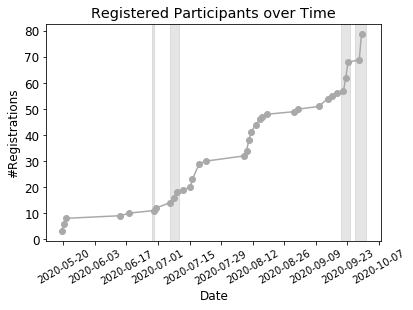

In [22]:
# we replaced the actualy pseudonyms with numbers here, to blind who registered when
data = [['1', 'Germany', '2020-05-20'],
        ['2', 'Germany', '2020-05-20'],
        ['3', 'Germany', '2020-05-20'],
        ['4', 'Germany', '2020-05-21'],
        ['5', 'United States of America', '2020-05-21'],
        ['6', 'Canada', '2020-05-21'],
        ['7', 'India', '2020-05-22'],
        ['8', 'Iran', '2020-05-22'],
        ['9', 'Australia', '2020-06-15'],
        ['10', 'Germany', '2020-06-19'],
        ['11', 'Netherlands', '2020-06-30'],
        ['12', 'Netherlands', '2020-07-01'],
        ['13', 'Italy', '2020-07-07'],
        ['14', 'Netherlands', '2020-07-07'],
        ['15', 'United Kingdom', '2020-07-09'],
        ['16', 'Canada', '2020-07-09'],
        ['17', 'Canada', '2020-07-10'],
        ['18', 'Bangladesh', '2020-07-10'],
        ['19', 'Germany', '2020-07-13'],
        ['20', 'Australia', '2020-07-16'],
        ['21', 'Canada', '2020-07-17'],
        ['22', 'India', '2020-07-17'],
        ['23', 'Canada', '2020-07-17'],
        ['24', 'China', '2020-07-20'],
        ['25', 'Slovakia', '2020-07-20'],
        ['26', 'China', '2020-07-20'],
        ['27', 'China', '2020-07-20'],
        ['28', 'New Zealand', '2020-07-20'],
        ['29', 'Turkey', '2020-07-20'],
        ['30', 'Iran', '2020-07-23'],
        ['31', 'Australia', '2020-08-09'],
        ['32', 'Germany', '2020-08-09'],
        ['33', 'United States of America', '2020-08-10'],
        ['34', 'Norway', '2020-08-10'],
        ['35', 'Netherlands', '2020-08-11'],
        ['36', 'United States of America', '2020-08-11'],
        ['37', 'United States of America', '2020-08-11'],
        ['38', 'Germany', '2020-08-11'],
        ['39', 'Canada', '2020-08-12'],
        ['40', 'Israel', '2020-08-12'],
        ['41', 'Finland', '2020-08-12'],
        ['42', 'United States of America', '2020-08-14'],
        ['43', 'United Kingdom', '2020-08-14'],
        ['44', 'Turkey', '2020-08-14'],
        ['45', 'Germany', '2020-08-16'],
        ['46', 'Germany', '2020-08-16'],
        ['47', 'Germany', '2020-08-17'],
        ['48', 'Germany', '2020-08-19'],
        ['49', 'United States of America', '2020-08-31'],
        ['50', 'United States of America', '2020-09-02'],
        ['51', 'Canada', '2020-09-11'],
        ['52', 'Germany', '2020-09-15'],
        ['53', 'Italy', '2020-09-15'],
        ['54', 'Switzerland', '2020-09-15'],
        ['55', 'Germany', '2020-09-17'],
        ['56', 'Hungary', '2020-09-19'],
        ['57', 'Macedonia', '2020-09-22'],
        ['58', 'Canada', '2020-09-23'],
        ['59', 'China', '2020-09-23'],
        ['60', 'China', '2020-09-23'],
        ['61', 'China', '2020-09-23'],
        ['62', 'China', '2020-09-23'],
        ['63', 'China', '2020-09-24'],
        ['64', 'China', '2020-09-24'],
        ['65', 'China', '2020-09-24'],
        ['66', 'China', '2020-09-24'],
        ['67', 'China', '2020-09-24'],
        ['68', 'China', '2020-09-24'],
        ['69', 'Brasil', '2020-09-29'],
        ['70', 'Norway', '2020-09-30'],
        ['71', 'China', '2020-09-30'],
        ['72', 'China', '2020-09-30'],
        ['73', 'China', '2020-09-30'],
        ['74', 'Canada', '2020-09-30'],
        ['75', 'United Kingdom', '2020-09-30'],
        ['76', 'Germany', '2020-09-30'],
        ['77', 'United States of America', '2020-09-30'],
        ['78', 'New Zealand', '2020-09-30'],
        ['79', 'Slovakia', '2020-09-30'],
       ]

df = pd.DataFrame(data, columns=['Pseudonym', 'CountryName', 'Date'])

df['number'] = df.index+1
grouped_df = df.groupby('Date').max()
grouped_df.index = pd.to_datetime(grouped_df.index)

rule = rrulewrapper(WEEKLY, interval=2)
loc = RRuleLocator(rule)
formatter = DateFormatter('%Y-%m-%d')

fig, ax = plt.subplots()
ax.plot_date(x=grouped_df.index, y=grouped_df['number'], xdate=True, linestyle='-', color='darkgrey')
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.axvspan('2020-06-29', '2020-06-30', color='grey', alpha=0.2) # msr
ax.axvspan('2020-07-07', '2020-07-11', color='grey', alpha=0.2) # msr
ax.axvspan('2020-09-21', '2020-09-25', color='grey', alpha=0.2) # ase
ax.axvspan('2020-09-27', '2020-10-02', color='grey', alpha=0.2) # scam/icsme
ax.set_title('Registered Participants over Time')
ax.set_xlabel('Date')
ax.set_ylabel('#Registrations')
plt.savefig('figures/participants_over_time.pdf', bbox_inches='tight')

Next, we look at how much each participant labeled, their consensus, and how this happened over time. The data for the consensus ratios may not completely match the data from the article, as this was based on the uncorrected data and not updated after the correction, to not penalize participants who could not correct their data. 

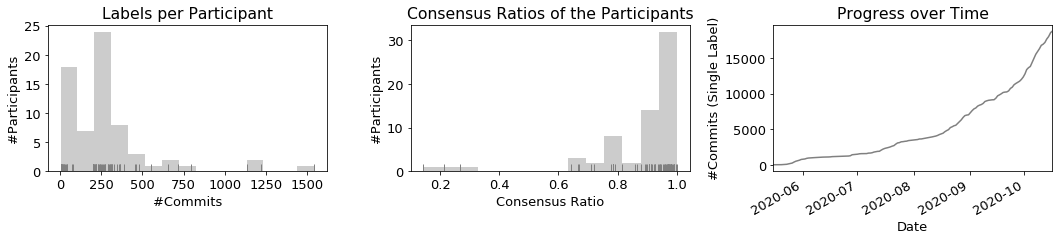

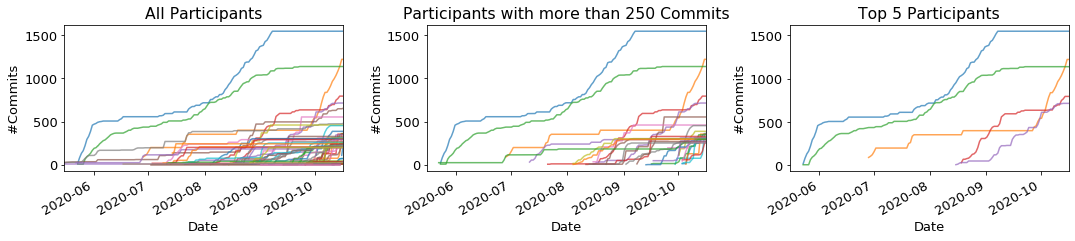

In [23]:
with open('data/leaderboard_dump.json') as json_file:
    data = json.load(json_file)

# progress over time
timestamps = []
for timestep in data:
    timestamps.append(timestep['created_at'])
all_participants = list(data[-1]['users'].keys())
time_df = pd.DataFrame(index=timestamps, columns=all_participants)
for timestep in data:
    for user, progress in timestep['users'].items():
        time_df.loc[timestep['created_at'], user] = progress['commits']
time_df.index = pd.to_datetime(time_df.index)

# user consensus
user_consensus = {}
for result in completed:
    for user, label_dict in result['lines_manual'].items():
        if user in ['testuser', 'labeltest', 'atx']:
            continue # these are three dummy accounts for testing that we only used on the tutorial data
        if user not in user_consensus:
            user_consensus[user] = {'lines_total': 0, 'lines_consensus': 0}
        for label, lines in label_dict.items():
            user_consensus[user]['lines_total'] += len(lines)
            if label in result['label_dict_by_type']:
                user_consensus[user]['lines_consensus'] += len(set(lines) & set(result['label_dict_by_type'][label]))
            if label=='test' and 'test_doc_whitespace' in result['label_dict_by_type']:
                user_consensus[user]['lines_consensus'] += len(set(lines) & set(result['label_dict_by_type']['test_doc_whitespace']))
            elif label=='refactoring':
                if'test' in result['label_dict_by_type']:
                    user_consensus[user]['lines_consensus'] += len(set(lines) & set(result['label_dict_by_type']['test']))
                if 'test_doc_whitespace' in result['label_dict_by_type']:
                    user_consensus[user]['lines_consensus'] += len(set(lines) & set(result['label_dict_by_type']['test_doc_whitespace']))
            elif label=='unrelated' and not java_filename_filter(result['file'], production_only=False) and 'documentation' in result['label_dict_by_type']:
                user_consensus[user]['lines_consensus'] += len(set(lines) & set(result['label_dict_by_type']['documentation']))
            elif label=='documentation':
                if 'test' in result['label_dict_by_type']:
                    user_consensus[user]['lines_consensus'] += len(set(lines) & set(result['label_dict_by_type']['test']))
                if 'test_doc_whitespace' in result['label_dict_by_type']:
                    user_consensus[user]['lines_consensus'] += len(set(lines) & set(result['label_dict_by_type']['test_doc_whitespace']))
                if 'doc_whitespace' in result['label_dict_by_type']:
                    user_consensus[user]['lines_consensus'] += len(set(lines) & set(result['label_dict_by_type']['doc_whitespace']))
            elif label=='whitespace':
                if 'test' in result['label_dict_by_type']:
                    user_consensus[user]['lines_consensus'] += len(set(lines) & set(result['label_dict_by_type']['test']))
                if 'test_doc_whitespace' in result['label_dict_by_type']:
                    user_consensus[user]['lines_consensus'] += len(set(lines) & set(result['label_dict_by_type']['test_doc_whitespace']))
                if 'doc_whitespace' in result['label_dict_by_type']:
                    user_consensus[user]['lines_consensus'] += len(set(lines) & set(result['label_dict_by_type']['doc_whitespace']))
        # discard lines without consensus
        if 'None' in result['label_dict_by_type']:
            user_consensus[user]['lines_total'] -= len(result['label_dict_by_type']['None'])
        if 'no_bugfix' in result['label_dict_by_type']:
            user_consensus[user]['lines_total'] -= len(result['label_dict_by_type']['no_bugfix'])
for user in user_consensus:
    user_consensus[user]['ratio'] = user_consensus[user]['lines_consensus']/user_consensus[user]['lines_total']

# sort columns by number of commits labeled
time_df = time_df[time_df.max().sort_values(ascending=False).index]


# larger font size, because we have three plots
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(1,3, figsize=(18,3))
ax = axes[0]
sns.distplot(time_df.max(), hist=True, rug=True, kde=False, bins=15, color='grey', ax=ax)
ax.set_xlabel('#Commits')
ax.set_ylabel('#Participants')
ax.set_title('Labels per Participant')
ax = axes[1]
sns.distplot(pd.DataFrame(user_consensus).transpose()['ratio'], rug=True, hist=True, kde=False, color='grey', ax=ax)
ax.set_xlabel('Consensus Ratio')
ax.set_ylabel('#Participants')
ax.set_title('Consensus Ratios of the Participants')
ax = axes[2]
time_df.sum(axis=1).plot(ax=ax, color='grey')
ax.set_xlabel('Date')
ax.set_ylabel('#Commits (Single Label)')
ax.set_title('Progress over Time')
plt.subplots_adjust(wspace=0.3)
plt.savefig('figures/participant_stats.pdf', bbox_inches='tight')

fig, axes = plt.subplots(1,3, figsize=(18,3))
ax = axes[0]
time_df.plot(alpha=0.7, legend=None, ax=ax)
ax.set_title('All Participants')
ax.set_xlabel('Date')
ax.set_ylabel('#Commits')
ax = axes[1]
time_df.loc[:,(time_df.max()>250)].drop(['sherbold', 'atrautsch'], axis=1).plot(alpha=0.7, legend=None, ax=ax)
ax.set_title('Participants with more than 250 Commits')
ax.set_xlabel('Date')
ax.set_ylabel('#Commits')
ax = axes[2]
time_df.loc[:,(time_df.max()>600)].drop(['atrautsch'], axis=1).plot(alpha=0.7, legend=None, ax=ax)
ax.set_title('Top 5 Participants')
ax.set_xlabel('Date')
ax.set_ylabel('#Commits')
plt.subplots_adjust(wspace=0.3)
plt.savefig('figures/progress_over_time.pdf', bbox_inches='tight')
plt.rcParams.update({'font.size': 12})

## Survey Results

We also asked participants two survey questions. Here are the results.

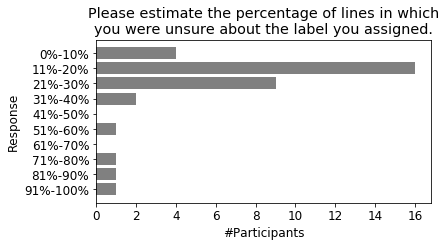

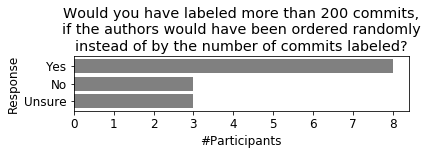

In [25]:
labels = ['0%-10%', '11%-20%', '21%-30%', '31%-40%', '41%-50%', '51%-60%', '61%-70%', '71%-80%', '81%-90%', '91%-100%']
values = [4, 16, 9, 2, 0, 1, 0, 1, 1, 1]

plt.figure(figsize=(6,3))
ax = plt.gca()
ax.barh(range(len(values)), width=values, tick_label=labels, color='grey')
ax.invert_yaxis()
ax.set_title('Would you have labeled ')
ax.set_ylabel('Response')
ax.set_xlabel('#Participants')
ax.set_title('Please estimate the percentage of lines in which\nyou were unsure about the label you assigned.')
plt.savefig('figures/survey_certainty.pdf', bbox_inches='tight')

labels = ['Yes', 'No', 'Unsure']
values = [8, 3, 3]

plt.figure(figsize=(6,1))
ax = plt.gca()
ax.barh(range(len(values)), width=values, tick_label=labels, color='grey')
ax.invert_yaxis()
ax.set_ylabel('Response')
ax.set_xlabel('#Participants')
ax.set_title('Would you have labeled more than 200 commits,\nif the authors would have been ordered randomly\ninstead of by the number of commits labeled?')
plt.savefig('figures/survey_gamification.pdf', bbox_inches='tight')